In [48]:
''' Import packages. '''
# Time packages
import calendar, cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy, numba
# Local data storage packages
import functools, importlib, os, pickle, collections, sys
import pandas as pd, xarray as xr, nc_time_axis
xr.set_options(keep_attrs=True)
# Visualization tools
import cartopy, cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Local imports
sys.path.insert(1, '/projects/GEOCLIM/gr7610/scripts')
import derived, utilities, visualization, track_TCs, tc_analysis
importlib.reload(track_TCs);
importlib.reload(tc_analysis)
importlib.reload(utilities);
importlib.reload(visualization);
importlib.reload(derived);

In [91]:
86400 / 90

960.0

In [2]:
def get_field_name_alias(field_name: str) -> str:

    field_name_aliases = {'WVP': 'PW',
                          'netrad_toa': 'R$_\mathrm{TOA}$',
                          'olr': 'R$_\mathrm{TOA, LW, up}$',
                          'swabs_toa': 'R$_\mathrm{TOA, SW, abs}$',
                          'precip': 'P',
                          'evap': 'E',
                          'p-e': 'P-E',
                          'trans_atm': 'Q$_\mathrm{atm}$',
                          'trans_cpT': 'Q$_\mathrm{sens}$',
                          'trans_lq': 'Q$_\mathrm{lat}$'}
    
    return field_name_aliases[field_name] if field_name in field_name_aliases.keys() else field_name

In [3]:
def get_derived_fields(dataset: xr.Dataset,
                       diagnostic: bool=False) -> xr.Dataset:

    diagnostic_tag = '[get_derived_fields()]'

    assert isinstance(dataset, xr.Dataset), f'Input data must be an xarray Dataset. It is currently of type {type(dataset)}.'

    # Define each derived field by its constituent fields and the derivation function.
    derived_fields = {'p-e': {'field_names': ['precip', 'evap'],
                              'func': lambda x: x['precip'] - x['evap'],
                              'long_name': 'surface moisture flux',
                              'units': 'mm d$^{-1}$'},
                      'swabs_toa': {'field_names': ['swdn_toa', 'swup_toa'],
                                    'func': lambda x: x['swdn_toa'] - x['swup_toa'],
                                    'long_name': 'absorbed shortwave radiation',
                                    'units': 'W m$^{-2}$'},
                      'netrad_surf': {'field_names': ['swup_sfc', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc'],
                                      'func': lambda x: -x['swup_sfc'] + x['swdn_sfc'] - x['lwup_sfc'] + x['lwdn_sfc'],
                                      'long_name': 'net downward surface radiative flux',
                                      'units': 'W m$^{-2}$'},
                      'le': {'field_names': ['evap'],
                             'func': lambda x: (x['evap'] / 86400) * utilities.get_constants('L_v'),
                             'long_name': 'latent heat flux',
                             'units': 'W m$^{-2}$'},
                      'div_atm': {'field_names': ['netrad_toa', 'netrad_surf', 'le', 'shflx'],
                                  'func': lambda x: x['netrad_toa'] - x['netrad_surf'] +  x['le'] + x['shflx'],
                                  'long_name': 'horizontal divergence of atmospheric energy',
                                  'units': 'W m$^{-2}$'},
                      'trans_atm': {'field_names': ['div_atm'],
                                    'func': lambda x: inferred_heat_transport(dataset=x, field_name='div_atm'),
                                    'long_name': 'northward transport of atmospheric energy',
                                    'units': 'PW'},
                      'div_lq': {'field_names': ['p-e'],
                                 'func': lambda x: -(x['p-e'] / 86400) * utilities.get_constants('L_v'),
                                 'long_name': 'horizontal divergence of latent energy',
                                 'units': 'W m$^{-2}$'},
                      'trans_lq': {'field_names': ['div_lq'],
                                   'func': lambda x: inferred_heat_transport(dataset=x, field_name='div_lq'),
                                   'long_name': 'northward transport of latent energy',
                                   'units': 'PW'},
                      'trans_cpT': {'field_names': ['trans_lq', 'trans_atm'],
                                    'func': lambda x: x['trans_atm'] - x['trans_lq'],
                                    'long_name': 'northward transport of sensible heat',
                                    'units': 'PW'}}

    # Iterate over all fields and derived if the constituent fields are in the dataset.
    for derived_field, derived_dict in derived_fields.items():
        if diagnostic:
            print(f'{diagnostic_tag} Inspecting data to derive field {derived_field} using {derived_dict['field_names']}...')
            
        # Check that all fields for derived quantity are in dataset
        check_fields = [field in dataset.data_vars for field in derived_dict['field_names']]
        if not (sum(check_fields) == len(derived_dict['field_names'])):
            if diagnostic:
                print(f'{diagnostic_tag} not all fields found for data when deriving {derived_field}; only fields ...')
            continue
        # Derive the quantity
        dataset[derived_field] = derived_dict['func'](dataset)
        
    return dataset

In [4]:
def inferred_heat_transport(dataset: xr.DataArray,
                            field_name: str='netrad_toa',
                            flux_adjustment: int|float=0,
                            normalize_units: str='PW'):
    '''
    Credit: Brian Rose, UAlbany; https://github.com/brian-rose/ClimateLaboratoryBook/blob/main/courseware/advanced-heat-transport.ipynb.
    Modifications made by G. Rios.
    
    Compute heat transport as integral of local energy imbalance.
    As either numpy array or xarray.DataArray, returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''

    latitude_dimension_name = 'grid_yt'
    # Get averaging dimensions
    averaging_dimensions = [d for d in dataset.dims if d != latitude_dimension_name]
    # Get degrees latitude in units of radians
    lat_radians = dataset[latitude_dimension_name] * np.pi/180
    # Weigh the dataset by latitude
    
    dataset_weighted = (dataset[field_name] - flux_adjustment).mean(averaging_dimensions) * np.cos(lat_radians)
    # Get global integral
    integral = scipy.integrate.cumulative_trapezoid(dataset_weighted, 
                                                    x=lat_radians, 
                                                    initial=0., 
                                                    axis=dataset_weighted.get_axis_num(latitude_dimension_name))

    unit_prefix = {'PW': 1e-15, 'MW': 1e-6, 'GW': 1e-9, 'KW': 1e-3}
    
    result = (unit_prefix[normalize_units] * 2 * np.pi * utilities.get_constants('a')**2 * integral)
    
    if isinstance(dataset_weighted, xr.DataArray):
        result_xarray = dataset_weighted.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

In [21]:
def get_experiment_set(configurations: dict,
                       field_names: str|list[str],
                       pressure_level: int=500,
                       data_type: str='atmos_month') -> dict:

    ''' 
    Method to load data for a pair of experiments and their difference. 
    Returns a dictionary of time-mean data with the difference of the configurations provided.
    
    `configurations` is defined in the structure of: 
    {<CONFIGURATION_NAME>: {'model_name': <MODEL_NAME>, 'experiment_name': <EXPERIMENT_NAME>}
    '''

    diagnostic_tag = '[get_experiment_set]'
    
    datasets, experiment_names, configuration_names = {}, [], []
    min_year, max_year = 2, 30

    # Perform intake controls
    if isinstance(field_names, str):
        field_names = [field_names]
    assert len(configurations) == 2, 'Only a pair of configurations can be handled at a time.'

    # Iterate through each configuration
    for configuration_name in configurations.keys():

        print(f'{diagnostic_tag} processing configuration {configuration_name}...')

        model_name, experiment_name = [configurations[configuration_name]['model_name'],
                                       configurations[configuration_name]['experiment_name']]
        configuration_names.append(configuration_name)
        experiment_names.append(experiment_name)

        dirname = f'/scratch/gpfs/GEOCLIM/gr7610/tiger3/{model_name}/work/{experiment_name}_tiger3_intelmpi_24_540PE/POSTP'

        # Obtain pathnames matching the iterand criteria
        pathnames = [f'{dirname}/{year:04d}0101.{data_type}.nc' for year in range(min_year, max_year)]
        pathnames = [pathname for pathname in pathnames if pathname.split('/')[-1] in os.listdir(dirname)]

        # Pull data
        datasets[configuration_name] = xr.open_mfdataset(pathnames)[field_names]
        # Find matching pressure level if requested, else load planar data
        # Obtain time-mean
        if 'pfull' in datasets[configuration_name].dims:
            datasets[configuration_name] = datasets[configuration_name].sel(pfull=pressure_level, 
                                                                            method='nearest').load()
            # for field_name in field_names:
            #     if 'pfull' in datasets[configuration_name][field_name]
        else:
            datasets[configuration_name] = datasets[configuration_name].load()
        # Adjust values based on field name (for example, precipitation and evaporation should be 
        # multiplied by 86400 to convert kg/m^2/s to mm/d)
        datasets[configuration_name] = utilities.field_correction(data=datasets[configuration_name])
        # Apply latitude weighting
        datasets[configuration_name] = datasets[configuration_name].weighted(np.cos(np.deg2rad(datasets[configuration_name].grid_yt))).mean('grid_xt')
        # Acquire derived values
        datasets[configuration_name] = get_derived_fields(datasets[configuration_name])

    # Load data
    meridional_extent = slice(-90, 90)
    difference = (datasets[configuration_names[0]] - datasets[configuration_names[1]]).sel(grid_yt=meridional_extent)

    difference_configuration_name = f'DIFF.{configuration_names[0]}-{configuration_names[1]}'
    datasets[difference_configuration_name] = difference

    return datasets

In [59]:
def monthly_TC_density(configuration_names: str|list[str],
                       # year_range: list[int, int] | tuple[int, int],
                       bin_resolution: float=2.5) -> dict:

    ''' 
    Generate dictionary of xArray DataArrays (one per experiment) with monthly climatology of TC track density. 
    Useful for annual cycle plots. 
    '''

    if isinstance(configuration_names, str):
        configuration_names = [configuration_names]

    # Remove any experiments that may be a difference
    configuration_names = [configuration_name for configuration_name in configuration_names if
                           'DIFF' not in configuration_names]
    
    # Initialize container dictionary
    monthly_track_density = {}
    # Iterate over experiments to pull data
    for config_name in configuration_names:
        monthly_track_density[config_name] = {}
        
        # Determine configuration-specific model and experiment name
        config_model_name, config_experiment_name = [config_name.split(':')[0],
                                                     f'CTL1990.{config_name.split(':')[1]}']

        print(f'[monthly_TC_density()] configuration: {config_name}; model name: {config_model_name}; experiment name: {config_experiment_name}')
        
        # Iterate over each month
        for month in range(1, 13):
            # Pull TC density for the iterand month
            track_density = tc_analysis.TC_density(model_names=config_model_name,
                                                   experiment_names=config_experiment_name,
                                                   month_range=(month, month + 1),
                                                   bin_resolution=bin_resolution,
                                                   diagnostic=False)[config_model_name][config_experiment_name]
            # Expand array along a new axis for month. This allows for future concatenation along a time axis.
            track_density_values = np.expand_dims(track_density.values, axis=0) 
            # Create the xArray DataArray for this month
            monthly_track_density[config_name][month] = xr.DataArray(data=track_density_values,
                                                                    dims=['month', 'grid_yt', 'grid_xt'],
                                                                    coords={'month': (['month'], [month]),
                                                                            'grid_yt': (['grid_yt'], track_density.index.values),
                                                                            'grid_xt': (['grid_xt'], track_density.columns.values)})
        # Concatenate all monthly DataArrays for the iterand experiment
        monthly_track_density[config_name] = xr.concat(monthly_track_density[config_name].values(), dim='month')
    # # Generate the difference DataArray if 2 experiments are provided
    # if len(experiment_names) == 2:
    #     monthly_track_density[f'{config_name[0]}-{experiment_names[1]}'] = monthly_track_density[experiment_names[0]] - monthly_track_density[experiment_names[1]]

    return monthly_track_density

In [84]:
def plot_annual_cycle(dataset: dict,
                      config_name: str,
                      field_name: str,
                      monthly_track_density: dict|None = None,
                      basin_name: str='global',
                      extrema: tuple[int|float, int|float] | None=None,
                      level: str|None=None):

    long_name, units = visualization.field_properties(field_name)
    basins, basin_masks = visualization.basins()
    basin_mask = basin_masks[basin_name]

    dataset = dataset[config_name][field_name].where(basin_mask)
    annual_cycle = dataset.mean('grid_xt').groupby('time.month').mean()
    
    GCM_norm, GCM_cmap = visualization.norm_cmap(annual_cycle, field_name, white_adjust=False, extrema=extrema)
    
    monthly_basin_mask = basin_mask.expand_dims({'month': monthly_track_density[config_name].month})
    monthly_basin_mask = monthly_basin_mask.interp(grid_xt=monthly_track_density[config_name].grid_xt,
                                                   grid_yt=monthly_track_density[config_name].grid_yt)
    monthly_track_density_difference = monthly_track_density[config_name].where(monthly_basin_mask).mean('grid_xt')
    TC_density_norm, TC_density_cmap = visualization.norm_cmap(monthly_track_density_difference, 
                                                               field='TC_activity', 
                                                               num_bounds=8)
    TC_density_levels = TC_density_norm.boundaries[np.where(TC_density_norm.boundaries != 0)]

    ''' Begin visualization. '''

    fig, ax = plt.subplots(figsize=(5, 3), dpi=144)
    
    ax.axhline(0, c='k', lw=0.5)
    ax.contourf(annual_cycle.month, annual_cycle.grid_yt, annual_cycle.T,
                notm=GCM_norm, cmap=GCM_cmap, levels=len(GCM_norm.boundaries))
    
    GCM_cax = ax.inset_axes([1.03, 0, 0.03, 1])
    GCM_colorbar = fig.colorbar(matplotlib.cm.ScalarMappable(GCM_norm, GCM_cmap), 
                                cax=GCM_cax)
    GCM_colorbar.set_label(units, rotation=270, labelpad=15)
    

    TC_density_im = ax.contour(monthly_track_density_difference.month,
                               monthly_track_density_difference.grid_yt,
                               monthly_track_density_difference.T,
                               levels=TC_density_levels,
                               linestyles='--',
                               cmap=TC_density_cmap,
                               linewidths=1.5)
    ax.clabel(TC_density_im, levels=TC_density_levels)
    
    ax.set_xlim([1, 12]);
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.set_ylim([-60, 60]);
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(15))
    ax.set_xticklabels([utilities.month_letter(month_number) for month_number in range(0, 13)])
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Latitude')

    level_string = f' at {level}' if level else ''
    title_string = f'{long_name[0].upper() + long_name[1:]}{level_string}\n{config_name}'
    ax.set_title(title_string, loc='left', ha='left', fontsize=9);

In [82]:
model_names = ['AM2.5', 'HIRAM']
field_names = ['WVP', 'precip', 'evap', 'netrad_toa', 'olr', 'swup_toa', 'swdn_toa', 'rh']
experiment_names = ['TIMEVAR']

data = {}
for model_name in model_names:
    for experiment_name in experiment_names:
        
        configurations = {'CTL': {'model_name': model_name,
                                  'experiment_name': f'CTL1990.{experiment_name}',
                                  'npes': 540},
                          'EXP': {'model_name': model_name,
                                  'experiment_name': f'CTL1990_SWISHE.{experiment_name}',
                                  'npes': 540},}
        
        TMP = get_experiment_set(configurations=configurations, 
                                 pressure_level=500,
                                 field_names=field_names)
    
        TMP = {f'{model_name}:{experiment_name}:{k}': v for k, v in TMP.items()}
        data.update(TMP)

[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...
[get_experiment_set] processing configuration CTL...
[get_experiment_set] processing configuration EXP...


[monthly_TC_density()] configuration: AM2.5:TIMEVAR:DIFF.CTL-EXP; model name: AM2.5; experiment name: CTL1990.TIMEVAR
[monthly_TC_density()] configuration: HIRAM:TIMEVAR:DIFF.CTL-EXP; model name: HIRAM; experiment name: CTL1990.TIMEVAR


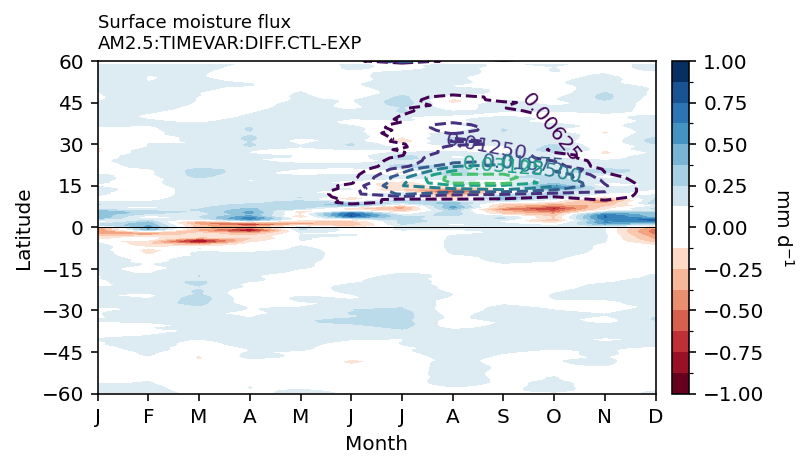

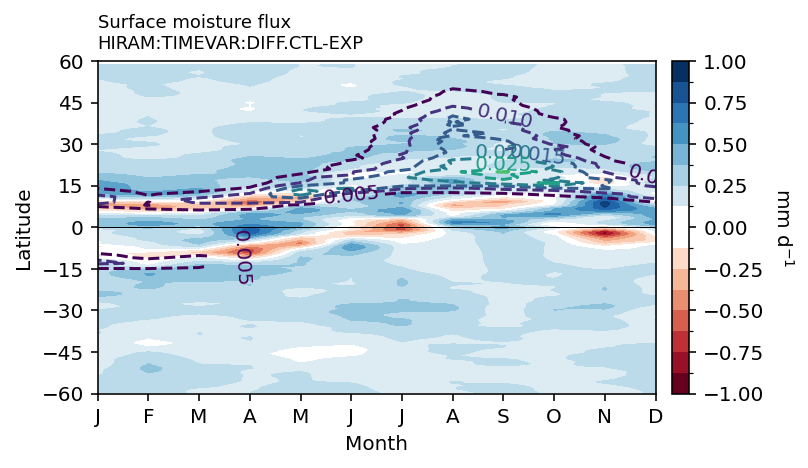

In [85]:
configuration = 'DIFF.CTL-EXP'
assert configuration in ['CTL', 'EXP', 'DIFF.CTL-EXP']

configuration_names = [f'AM2.5:TIMEVAR:{configuration}',
                       f'HIRAM:TIMEVAR:{configuration}',]
# Load track density climatology
monthly_track_density = monthly_TC_density(configuration_names=configuration_names,
                                           bin_resolution=1)

for field_name in ['p-e']:
    for configuration_name in configuration_names:
        plot_annual_cycle(dataset=data,
                          config_name=configuration_name,
                          field_name=field_name,
                          monthly_track_density=monthly_track_density,
                          basin_name='global')